## Helpers

In [ ]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
import re
from collections import defaultdict
import pprint
import math
from typing import Tuple, List, Set, Callable


In [2]:
CPU_CORES = 16

In [3]:
def slope(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0:
        return 'inf'
    return QQ(dy) / QQ(dx)

In [4]:
def are_collinear(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

In [5]:
def greedy(n, priority):
    all_points = [(x, y) for x in range(n) for y in range(n)]
    shuffle(all_points)

    priorities = {p: priority(p) for p in all_points}
    active_points = set(all_points)
    selected = set()

    while active_points:
        p = max(active_points, key=lambda pt: priorities[pt])
        selected.add(p)
        active_points.remove(p)
        # print(f"Selected point: {p}, Priority: {priorities[p]}")
        active_points -= {
            q for q in active_points
            if any(are_collinear(p, s, q) for s in selected if s != p)
        }
    return sorted(selected)

In [6]:
def plot_no_three_in_line(points, n=None, title="No-3-in-line Set"):
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    if n is None:
        n = max(max(xs), max(ys)) + 1

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    plt.xticks(range(n))
    plt.yticks(range(n))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1, n)
    plt.ylim(-1, n)
    plt.show()


In [7]:
def find_missing_data(data):
    missing = {}
    for key, intervals in data.items():
        missing_entries = []
        for i, (start, end) in enumerate(intervals):
            if end == 'NO DATA':
                missing_entries.append((i, start))
        if missing_entries:
            missing[key] = missing_entries
    return missing

## Priorities

In [8]:
# NOISE = random.uniform(-0.1, 0.1) 
NOISE = 0.0

In [9]:
def square_corner_priority(n, sharpness=1, radius_scale=1.0):
    n = float(n)
    sharpness = float(sharpness)
    radius_scale = float(radius_scale)

    def priority(point):
        x, y = point
        nx = x / n
        ny = y / n
        norm = max(nx, ny)
        score = -abs(norm - radius_scale)**sharpness


        return score + NOISE
    return priority


In [10]:
def pnorm_circle_priority(n, p = 4, radius_scale=0.9):
    n = float(n)
    p = float(p)
    radius_scale = float(radius_scale)
    def priority(point):
        x, y = point
        nx = (2 * x / n) - 1
        ny = (2 * y / n) - 1
        norm = (abs(nx)**p + abs(ny)**p)**(1/p)

        return -abs(norm - radius_scale) + NOISE
    return priority

In [11]:
def square_shell_priority(n, sharpness=1, radius_scale=1.0):
    n = float(n)
    sharpness = float(sharpness)
    radius_scale = float(radius_scale)
    def priority(point):
        x, y = point
        nx = (2 * x / n) - 1
        ny = (2 * y / n) - 1
        norm = max(abs(nx), abs(ny))
        score = -abs(norm - radius_scale)**sharpness

        return score + NOISE
    return priority


## Comparisons

### inter

#### computations

In [77]:
ns = list(range(20, 210, 10))

In [ ]:
@parallel(ncpus=CPU_CORES)
def run_greedy_for_strategy(n, strategy_func):
    result = greedy(n, strategy_func(n))
    return len(result)

priority_functions = {
    'pnorm_circle': pnorm_circle_priority,
    'square_shell': square_shell_priority,
    'square_corner': square_corner_priority,
}


In [ ]:
inputs = [(n, strategy_func) for strategy_func in priority_functions.values() for n in ns]

results_parallel = run_greedy_for_strategy(inputs)

results = {key: [] for key in priority_functions.keys()}

for ((args, kwargs), len_result) in results_parallel:
    n, strategy_func = args
    for strategy_name, strategy_func_check in priority_functions.items():
        if strategy_func == strategy_func_check:
            results[strategy_name].append((n, len_result))

In [ ]:
print(f"Results: {results}")
missing_data = find_missing_data(results)
missing_inputs = [(n, priority_functions[name]) for name, entries in missing_data.items() for (_, n) in entries]
print(f"Missing data: {missing_data}")
print(f"Missing inputs: {missing_inputs}")

#### in case it breaks...

In [ ]:
max_retries = 5
retry_count = 0

while retry_count < max_retries:
    missing_inputs = [
        (n, strategy_func)
        for strategy_name, strategy_func in priority_functions.items()
        for n in ns
        if not any(isinstance(result, int) and nn == n for nn, result in results[strategy_name])
    ]

    if not missing_inputs:
        print("All data present, exiting retry loop.")
        break

    print(f"Retry #{retry_count + 1}: Recomputing {len(missing_inputs)} missing entries...")
    retry_results = run_greedy_for_strategy(missing_inputs)

    for (args, kwargs), len_result in retry_results:
        n, strategy_func = args
        for strategy_name, func in priority_functions.items():
            if strategy_func == func:
                records = [(nn, rr) for (nn, rr) in results.get(strategy_name, []) if nn != n]
                records.append((n, len_result))
                results[strategy_name] = sorted(records, key=lambda x: x[0])
                print(f"completed {strategy_name} for n={n} with result {len_result}")

    retry_count += 1
    time.sleep(1)

print("Final results:", results)


#### data & analysis

In [ ]:
results = {'pnorm_circle': [(20, 30), (30, 45), (40, 60), (50, 73), (60, 91), (70, 103), (80, 117), (90, 129), (100, 150), (110, 167), (120, 180), (130, 197), (140, 209), (150, 222), (160, 234), (170, 255), (180, 267), (190, 283), (200, 297)], 'square_shell': [(20, 32), (30, 45), (40, 60), (50, 76), (60, 88), (70, 105), (80, 117), (90, 132), (100, 148), (110, 162), (120, 181), (130, 193), (140, 207), (150, 223), (160, 242), (170, 250), (180, 267), (190, 286), (200, 293)], 'square_corner': [(20, 32), (30, 49), (40, 64), (50, 77), (60, 92), (70, 107), (80, 122), (90, 136), (100, 153), (110, 169), (120, 187), (130, 207), (140, 215), (150, 235), (160, 248), (170, 263), (180, 281), (190, 290), (200, 304)]}

Results: {'pnorm_circle': [(20, 30), (30, 45), (40, 60), (50, 73), (60, 91), (70, 103), (80, 117), (90, 129), (100, 150), (110, 167), (120, 180), (130, 197), (140, 209), (150, 222), (160, 234), (170, 255), (180, 267), (190, 283), (200, 297)], 'square_shell': [(20, 32), (30, 45), (40, 60), (50, 76), (60, 88), (70, 105), (80, 117), (90, 132), (100, 148), (110, 162), (120, 181), (130, 193), (140, 207), (150, 223), (160, 242), (170, 250), (180, 267), (190, 286), (200, 293)], 'square_corner': [(20, 32), (30, 49), (40, 64), (50, 77), (60, 92), (70, 107), (80, 122), (90, 136), (100, 153), (110, 169), (120, 187), (130, 207), (140, 215), (150, 235), (160, 248), (170, 263), (180, 281), (190, 290), (200, 304)]}


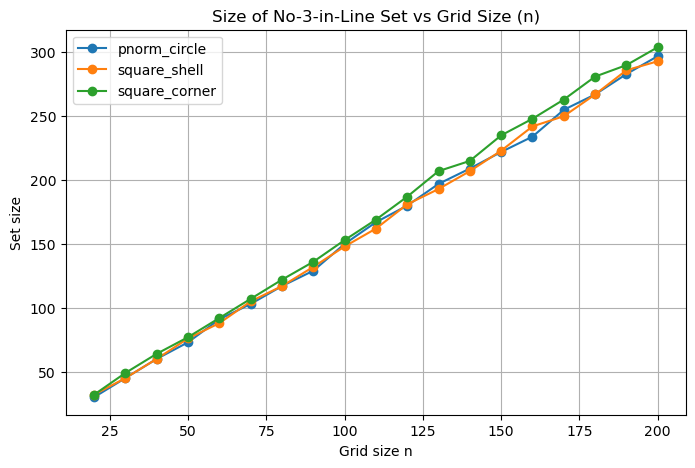

In [13]:

for strategy in results:
    results[strategy].sort(key=lambda x: x[0])
print(f"Results: {results}")

plt.figure(figsize=(8, 5))
for strategy, result_list in results.items():
    if result_list:
        ns, sizes = zip(*result_list)
        plt.plot(ns, sizes, marker='o', label=strategy, linestyle='-')

plt.title("Size of No-3-in-Line Set vs Grid Size (n)")
plt.xlabel("Grid size n")
plt.ylabel("Set size")
plt.grid(True)
plt.legend()
plt.show()

In [15]:
for method, points in results.items():
    x_vals = [p[0] for p in points]
    y_vals = [p[1] for p in points]
    data = list(zip(x_vals, y_vals))
    
    var('a b t')
    model(t) = a * t + b
    fit = find_fit(data, model, solution_dict=True)
    slope = fit[a]
    print(f"{method}: slope ≈ {slope:.4f}")

pnorm_circle: slope ≈ 1.4879
square_shell: slope ≈ 1.4802
square_corner: slope ≈ 1.5365


### intra

#### pnorm

##### computations

In [ ]:
@parallel(ncpus=CPU_CORES)
def finding_optimal_p(n, pnorm):
    result = greedy(n, pnorm_circle_priority(n, pnorm))
    print("")
    print(f"Greedy for n={n} with pnorm {pnorm}: {len(result)} points")
    return len(result)

In [121]:
ns_p = list(range(40, 410, 20))

In [ ]:
inputs = [(n, p/8) for p in range(16, 33, 1) for n in ns_p]

results_parallel = finding_optimal_p(inputs)
results_pnorm = {}

for ((args, kwargs), len_result) in results_parallel:
    n, pnorm = args  
    if pnorm not in results_pnorm:
        results_pnorm[pnorm] = []
    results_pnorm[pnorm].append((n, len_result))

print(f"Results: {results_pnorm}")

##### in case it breaks...

In [139]:
print(f"Results for p-norm: {results_pnorm}")
missing_data = find_missing_data(results_pnorm)
missing_inputs = [(n, pnorm) for pnorm, entries in missing_data.items() for (_, n) in entries]
print(f"Missing data: {missing_data}")
print(f"Missing inputs: {missing_inputs}")

Results for p-norm: {2: [(40, 54), (60, 89), (80, 116), (100, 142), (120, 174), (140, 206), (160, 235), (180, 265), (200, 292), (220, 318), (240, 355), (260, 381), (280, 410), (300, 432), (320, 466), (340, 500), (360, 514), (380, 547), (400, 582)], 17/8: [(40, 61), (60, 84), (80, 117), (100, 147), (120, 172), (140, 208), (160, 229), (180, 262), (200, 296), (220, 333), (240, 350), (260, 380), (280, 416), (300, 439), (320, 470), (340, 498), (360, 525), (380, 556), (400, 592)], 9/4: [(40, 62), (60, 84), (80, 117), (100, 137), (120, 179), (140, 212), (160, 241), (180, 263), (200, 300), (220, 329), (240, 356), (260, 381), (280, 414), (300, 437), (320, 473), (340, 494), (360, 515), (380, 554), (400, 577)], 19/8: [(40, 59), (60, 91), (80, 113), (100, 147), (120, 181), (140, 197), (160, 236), (180, 267), (200, 293), (220, 327), (240, 357), (260, 384), (280, 405), (300, 440), (320, 474), (340, 512), (360, 533), (380, 562), (400, 591)], 5/2: [(40, 60), (60, 92), (80, 118), (100, 150), (120, 181)

In [ ]:
max_retries = 5
retry_count = 0

while retry_count < max_retries:
    missing_data = find_missing_data(results_pnorm)
    missing_inputs = [(n, pnorm) for pnorm, entries in missing_data.items() for (_, n) in entries]
    print(f"Missing inputs: {missing_inputs}")

    if not missing_inputs:
        print("All data present, exiting retry loop.")
        break

    print(f"Retry #{retry_count + 1}: recomputing {len(missing_inputs)} missing entries...")

    for n, pnorm in missing_inputs:
        len_result = finding_optimal_p(n, pnorm) 

        records = [(nn, rr) for (nn, rr) in results_pnorm.get(pnorm, []) if nn != n]
        records.append((n, len_result))
        results_pnorm[pnorm] = sorted(records, key=lambda x: x[0])
        print(f"completed {pnorm} for n={n} with result {len_result}")

    retry_count += 1
    time.sleep(1)

print("Final results_pnorm:", results_pnorm)


Missing inputs: []
All data present, exiting retry loop.
Final results_pnorm: {2: [(10, 12), (40, 54), (70, 102), (100, 142), (130, 194), (160, 235), (190, 276), (220, 318)], 17/8: [(10, 12), (40, 61), (70, 104), (100, 147), (130, 190), (160, 229), (190, 274), (220, 333)], 9/4: [(10, 12), (40, 62), (70, 106), (100, 137), (130, 194), (160, 241), (190, 280), (220, 329)], 19/8: [(10, 12), (40, 59), (70, 102), (100, 147), (130, 188), (160, 236), (190, 278), (220, 327)], 5/2: [(10, 16), (40, 60), (70, 101), (100, 150), (130, 196), (160, 235), (190, 282), (220, 318)], 21/8: [(10, 16), (40, 61), (70, 104), (100, 150), (130, 190), (160, 237), (190, 279), (220, 321)], 11/4: [(10, 16), (40, 57), (70, 102), (100, 152), (130, 193), (160, 234), (190, 283), (220, 333)], 23/8: [(10, 16), (40, 59), (70, 98), (100, 147), (130, 195), (160, 240), (190, 287), (220, 332)], 3: [(10, 16), (40, 58), (70, 106), (100, 148), (130, 180), (160, 236), (190, 282), (220, 324)]}


##### data & analysis

In [167]:
results_pnorm = {2: [(40, 54), (60, 89), (80, 116), (100, 142), (120, 174), (140, 206), (160, 235), (180, 265), (200, 292), (220, 318), (240, 355), (260, 381), (280, 410), (300, 432), (320, 466), (340, 500), (360, 514), (380, 547), (400, 582)], 17/8: [(40, 61), (60, 84), (80, 117), (100, 147), (120, 172), (140, 208), (160, 229), (180, 262), (200, 296), (220, 333), (240, 350), (260, 380), (280, 416), (300, 439), (320, 470), (340, 498), (360, 525), (380, 556), (400, 592)], 9/4: [(40, 62), (60, 84), (80, 117), (100, 137), (120, 179), (140, 212), (160, 241), (180, 263), (200, 300), (220, 329), (240, 356), (260, 381), (280, 414), (300, 437), (320, 473), (340, 494), (360, 515), (380, 554), (400, 577)], 19/8: [(40, 59), (60, 91), (80, 113), (100, 147), (120, 181), (140, 197), (160, 236), (180, 267), (200, 293), (220, 327), (240, 357), (260, 384), (280, 405), (300, 440), (320, 474), (340, 512), (360, 533), (380, 562), (400, 591)], 5/2: [(40, 60), (60, 92), (80, 118), (100, 150), (120, 181), (140, 198), (160, 235), (180, 265), (200, 297), (220, 318), (240, 362), (260, 389), (280, 405), (300, 440), (320, 475), (340, 505), (360, 531), (380, 558), (400, 600)], 21/8: [(40, 61), (60, 88), (80, 118), (100, 150), (120, 187), (140, 212), (160, 237), (180, 269), (200, 300), (220, 321), (240, 365), (260, 387), (280, 426), (300, 446), (320, 479), (340, 507), (360, 527), (380, 563), (400, 599)], 11/4: [(40, 57), (60, 88), (80, 119), (100, 152), (120, 179), (140, 212), (160, 234), (180, 270), (200, 302), (220, 333), (240, 359), (260, 389), (280, 425), (300, 454), (320, 475), (340, 504), (360, 535), (380, 572), (400, 595)], 23/8: [(40, 59), (60, 85), (80, 120), (100, 147), (120, 178), (140, 208), (160, 240), (180, 272), (200, 299), (220, 332), (240, 367), (260, 388), (280, 417), (300, 449), (320, 475), (340, 505), (360, 535), (380, 569), (400, 596)], 3: [(40, 58), (60, 87), (80, 118), (100, 148), (120, 181), (140, 211), (160, 236), (180, 266), (200, 295), (220, 324), (240, 359), (260, 390), (280, 417), (300, 448), (320, 477), (340, 512), (360, 535), (380, 565), (400, 598)], 25/8: [(40, 57), (60, 88), (80, 121), (100, 148), (120, 183), (140, 208), (160, 234), (180, 267), (200, 302), (220, 330), (240, 358), (260, 386), (280, 419), (300, 455), (320, 478), (340, 512), (360, 536), (380, 558), (400, 603)], 13/4: [(40, 57), (60, 88), (80, 123), (100, 150), (120, 180), (140, 214), (160, 235), (180, 267), (200, 300), (220, 337), (240, 363), (260, 390), (280, 417), (300, 444), (320, 472), (340, 509), (360, 537), (380, 572), (400, 594)], 27/8: [(40, 59), (60, 93), (80, 121), (100, 148), (120, 186), (140, 209), (160, 239), (180, 269), (200, 298), (220, 325), (240, 359), (260, 386), (280, 418), (300, 440), (320, 481), (340, 505), (360, 536), (380, 566), (400, 594)], 7/2: [(40, 61), (60, 87), (80, 115), (100, 147), (120, 182), (140, 210), (160, 239), (180, 275), (200, 299), (220, 326), (240, 360), (260, 389), (280, 418), (300, 442), (320, 478), (340, 507), (360, 535), (380, 567), (400, 593)], 29/8: [(40, 61), (60, 87), (80, 117), (100, 149), (120, 182), (140, 210), (160, 241), (180, 265), (200, 303), (220, 324), (240, 360), (260, 391), (280, 425), (300, 447), (320, 475), (340, 512), (360, 536), (380, 565), (400, 598)], 15/4: [(40, 61), (60, 90), (80, 118), (100, 146), (120, 179), (140, 213), (160, 238), (180, 263), (200, 296), (220, 324), (240, 359), (260, 389), (280, 414), (300, 457), (320, 482), (340, 507), (360, 541), (380, 559), (400, 597)], 31/8: [(40, 60), (60, 91), (80, 117), (100, 149), (120, 180), (140, 208), (160, 237), (180, 263), (200, 293), (220, 329), (240, 357), (260, 386), (280, 416), (300, 443), (320, 481), (340, 502), (360, 537), (380, 563), (400, 592)], 4: [(40, 60), (60, 91), (80, 115), (100, 150), (120, 178), (140, 207), (160, 237), (180, 267), (200, 297), (220, 329), (240, 351), (260, 386), (280, 415), (300, 445), (320, 473), (340, 506), (360, 532), (380, 559), (400, 594)]}

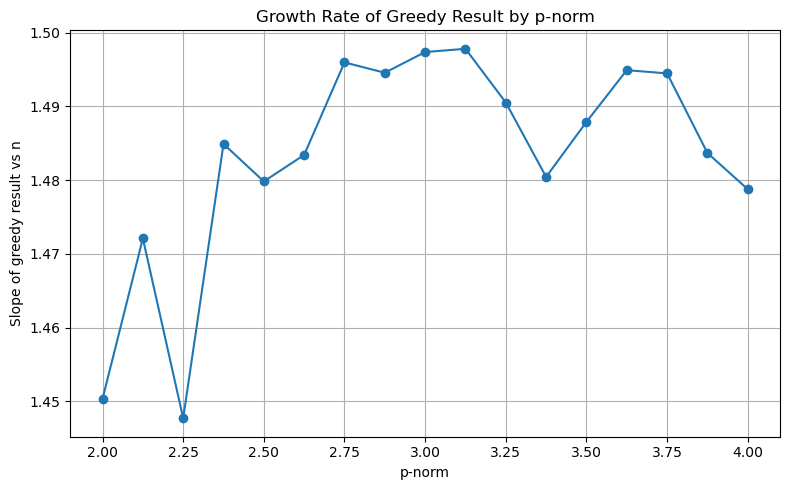

the maximum slope is 1.4978070175438596 for pnorm 3.125
the minimum slope is 1.447719298245614 for pnorm 2.25
the average slope is 1.4832198142357937


In [173]:
var('a b t')

pnorms = []
slopes = []

for pnorm, points in sorted(results_pnorm.items()):

    data = [(n, y) for n, y in points]

    model = a * t + b
    fit = find_fit(
        data,
        model,
        solution_dict=True,
        variables=[t],
        parameters=[a, b]
    )
    slope = fit[a]

    pnorms.append(float(pnorm))
    slopes.append(slope)
plt.figure(figsize=(8, 5))
plt.plot(pnorms, slopes, marker='o')
plt.xlabel("p-norm")
plt.ylabel("Slope of greedy result vs n")
plt.title("Growth Rate of Greedy Result by p-norm")
plt.grid(True)
plt.tight_layout()
plt.show()

sorteds = sorted(zip(pnorms, slopes), key=lambda x: x[1])
print(f"the maximum slope is {sorteds[-1][1]} for pnorm {sorteds[-1][0]}")
print(f"the minimum slope is {sorteds[0][1]} for pnorm {sorteds[0][0]}")
print(f"the average slope is {sum(slopes) / len(slopes)}")


Results: {2: [(40, 54), (60, 89), (80, 116), (100, 142), (120, 174), (140, 206), (160, 235), (180, 265), (200, 292), (220, 318), (240, 355), (260, 381), (280, 410), (300, 432), (320, 466), (340, 500), (360, 514), (380, 547), (400, 582)], 17/8: [(40, 61), (60, 84), (80, 117), (100, 147), (120, 172), (140, 208), (160, 229), (180, 262), (200, 296), (220, 333), (240, 350), (260, 380), (280, 416), (300, 439), (320, 470), (340, 498), (360, 525), (380, 556), (400, 592)], 9/4: [(40, 62), (60, 84), (80, 117), (100, 137), (120, 179), (140, 212), (160, 241), (180, 263), (200, 300), (220, 329), (240, 356), (260, 381), (280, 414), (300, 437), (320, 473), (340, 494), (360, 515), (380, 554), (400, 577)], 19/8: [(40, 59), (60, 91), (80, 113), (100, 147), (120, 181), (140, 197), (160, 236), (180, 267), (200, 293), (220, 327), (240, 357), (260, 384), (280, 405), (300, 440), (320, 474), (340, 512), (360, 533), (380, 562), (400, 591)], 5/2: [(40, 60), (60, 92), (80, 118), (100, 150), (120, 181), (140, 198

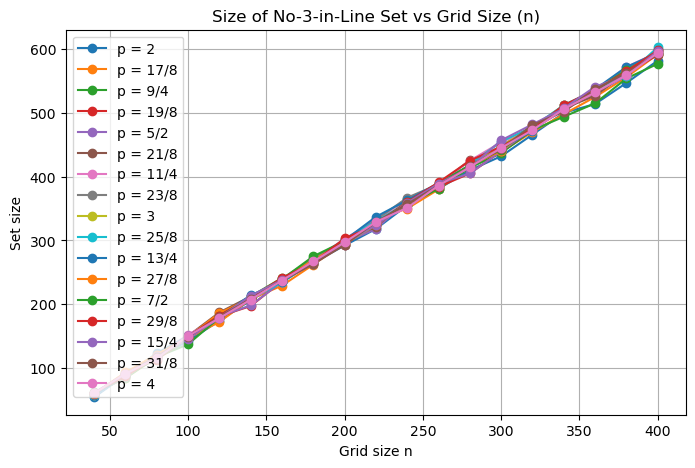

In [ ]:
for pnorm in results_pnorm:
    results_pnorm[pnorm].sort(key=lambda x: x[0])

plt.figure(figsize=(8, 5))

for pnorm, result_list in results_pnorm.items():

    data = [(n, y) for n, y in result_list]

    if len(data) >= 2:
        ns, sizes = zip(*data)
        plt.plot(ns, sizes, marker='o', label=f"p = {pnorm}", linestyle='-')

if plt.gca().get_legend_handles_labels()[0]:
    plt.legend()
else:
    print("No valid data to plot.")

plt.title("Size of No-3-in-Line Set vs Grid Size (n)")
plt.xlabel("Grid size n")
plt.ylabel("Set size")
plt.grid(True)
plt.show()


Results: {2: [(40, 54), (60, 89), (80, 116), (100, 142), (120, 174), (140, 206), (160, 235), (180, 265), (200, 292), (220, 318), (240, 355), (260, 381), (280, 410), (300, 432), (320, 466), (340, 500), (360, 514), (380, 547), (400, 582)], 17/8: [(40, 61), (60, 84), (80, 117), (100, 147), (120, 172), (140, 208), (160, 229), (180, 262), (200, 296), (220, 333), (240, 350), (260, 380), (280, 416), (300, 439), (320, 470), (340, 498), (360, 525), (380, 556), (400, 592)], 9/4: [(40, 62), (60, 84), (80, 117), (100, 137), (120, 179), (140, 212), (160, 241), (180, 263), (200, 300), (220, 329), (240, 356), (260, 381), (280, 414), (300, 437), (320, 473), (340, 494), (360, 515), (380, 554), (400, 577)], 19/8: [(40, 59), (60, 91), (80, 113), (100, 147), (120, 181), (140, 197), (160, 236), (180, 267), (200, 293), (220, 327), (240, 357), (260, 384), (280, 405), (300, 440), (320, 474), (340, 512), (360, 533), (380, 562), (400, 591)], 5/2: [(40, 60), (60, 92), (80, 118), (100, 150), (120, 181), (140, 198

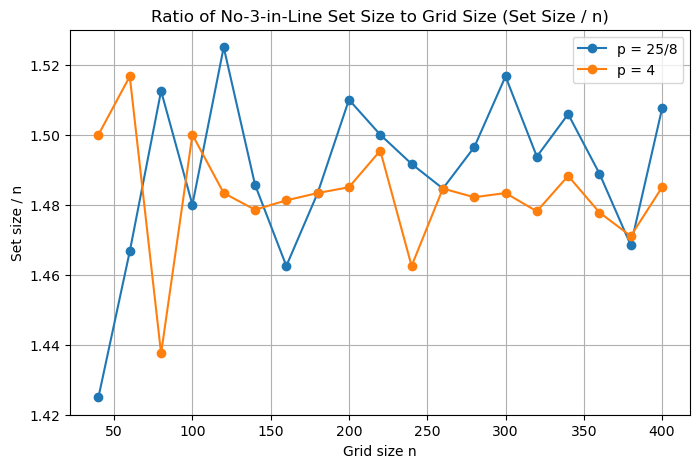

In [172]:

for pnorm in results_pnorm:
    results_pnorm[pnorm].sort(key=lambda x: x[0])

print(f"Results: {results_pnorm}")


plt.figure(figsize=(8, 5))


for pnorm, result_list in results_pnorm.items():

    data = [(n, y) for n, y in result_list]

    if not (pnorm in (3.125, 4)):
        continue

    if len(data) >= 2:
        ns, sizes = zip(*data)
        ratios = [size / n for n, size in data]
        plt.plot(ns, ratios, marker='o', label=f"p = {pnorm}", linestyle='-')


if plt.gca().get_legend_handles_labels()[0]:
    plt.legend()
else:
    print("No valid data to plot.")

plt.title("Ratio of No-3-in-Line Set Size to Grid Size (Set Size / n)")
plt.xlabel("Grid size n")
plt.ylabel("Set size / n")
plt.grid(True)
plt.show()


#### Counting

## Playground

### inter

#### computations

In [20]:
ns = list(range(20, 41, 10))

In [21]:
@parallel(ncpus=CPU_CORES)
def run_greedy_for_strategy(n, strategy_func):
    result = greedy(n, strategy_func(n))
    return len(result)

priority_functions = {
    'pnorm_circle': pnorm_circle_priority,
    'square_shell': square_shell_priority,
    'square_corner': square_corner_priority,
}


In [22]:
inputs = [(n, strategy_func) for strategy_func in priority_functions.values() for n in ns]

results_parallel = run_greedy_for_strategy(inputs)

results = {key: [] for key in priority_functions.keys()}

for ((args, kwargs), len_result) in results_parallel:
    n, strategy_func = args
    for strategy_name, strategy_func_check in priority_functions.items():
        if strategy_func == strategy_func_check:
            results[strategy_name].append((n, len_result))

In [23]:
print(f"Results: {results}")
missing_data = find_missing_data(results)
missing_inputs = [(n, priority_functions[name]) for name, entries in missing_data.items() for (_, n) in entries]
print(f"Missing data: {missing_data}")
print(f"Missing inputs: {missing_inputs}")

Results: {'pnorm_circle': [(20, 28), (30, 45), (40, 60)], 'square_shell': [(20, 31), (30, 45), (40, 60)], 'square_corner': [(20, 32), (30, 46), (40, 64)]}
Missing data: {}
Missing inputs: []


#### in case it breaks...

In [24]:
max_retries = 5
retry_count = 0

while retry_count < max_retries:
    missing_inputs = [
        (n, strategy_func)
        for strategy_name, strategy_func in priority_functions.items()
        for n in ns
        if not any(isinstance(result, int) and nn == n for nn, result in results[strategy_name])
    ]

    if not missing_inputs:
        print("All data present, exiting retry loop.")
        break

    print(f"Retry #{retry_count + 1}: Recomputing {len(missing_inputs)} missing entries...")
    retry_results = run_greedy_for_strategy(missing_inputs)

    for (args, kwargs), len_result in retry_results:
        n, strategy_func = args
        for strategy_name, func in priority_functions.items():
            if strategy_func == func:
                records = [(nn, rr) for (nn, rr) in results.get(strategy_name, []) if nn != n]
                records.append((n, len_result))
                results[strategy_name] = sorted(records, key=lambda x: x[0])
                print(f"completed {strategy_name} for n={n} with result {len_result}")

    retry_count += 1
    time.sleep(1)

print("Final results:", results)


All data present, exiting retry loop.
Final results: {'pnorm_circle': [(20, 28), (30, 45), (40, 60)], 'square_shell': [(20, 31), (30, 45), (40, 60)], 'square_corner': [(20, 32), (30, 46), (40, 64)]}


#### data & analysis

In [17]:
results = {'pnorm_circle': [(20, 30), (30, 45), (40, 60), (50, 73), (60, 91), (70, 103), (80, 117), (90, 129), (100, 150), (110, 167), (120, 180), (130, 197), (140, 209), (150, 222), (160, 234), (170, 255), (180, 267), (190, 283), (200, 297)], 'square_shell': [(20, 32), (30, 45), (40, 60), (50, 76), (60, 88), (70, 105), (80, 117), (90, 132), (100, 148), (110, 162), (120, 181), (130, 193), (140, 207), (150, 223), (160, 242), (170, 250), (180, 267), (190, 286), (200, 293)], 'square_corner': [(20, 32), (30, 49), (40, 64), (50, 77), (60, 92), (70, 107), (80, 122), (90, 136), (100, 153), (110, 169), (120, 187), (130, 207), (140, 215), (150, 235), (160, 248), (170, 263), (180, 281), (190, 290), (200, 304)]}

Results: {'pnorm_circle': [(20, 28), (30, 45), (40, 60)], 'square_shell': [(20, 31), (30, 45), (40, 60)], 'square_corner': [(20, 32), (30, 46), (40, 64)]}


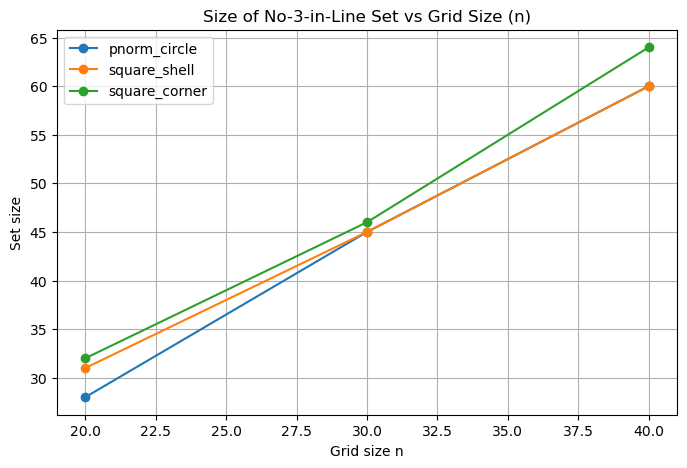

In [25]:

for strategy in results:
    results[strategy].sort(key=lambda x: x[0])
print(f"Results: {results}")

plt.figure(figsize=(8, 5))
for strategy, result_list in results.items():
    if result_list:
        ns, sizes = zip(*result_list)
        plt.plot(ns, sizes, marker='o', label=strategy, linestyle='-')

plt.title("Size of No-3-in-Line Set vs Grid Size (n)")
plt.xlabel("Grid size n")
plt.ylabel("Set size")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
for method, points in results.items():
    x_vals = [p[0] for p in points]
    y_vals = [p[1] for p in points]
    data = list(zip(x_vals, y_vals))
    
    var('a b t')
    model(t) = a * t + b
    fit = find_fit(data, model, solution_dict=True)
    slope = fit[a]
    print(f"{method}: slope ≈ {slope:.4f}")

pnorm_circle: slope ≈ 1.6000
square_shell: slope ≈ 1.4500
square_corner: slope ≈ 1.6000
